In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
!pip install catboost
!pip install xgboost
!pip install nbconvert

# Modelling:

In [3]:
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor,RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

# Data Import:

In [4]:
df=pd.read_csv("D:\Datasets to Practice\StudentsPerformance.csv")

In [5]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [6]:
X=df.drop(columns=['math score'],axis=1)

In [7]:
#this is our dependent features
X.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75


In [8]:
print("Categories in 'gender' variable:     ",end=" " )
print(df['gender'].unique())

print("Categories in 'race_ethnicity' variable:  ",end=" ")
print(df['race/ethnicity'].unique())

print("Categories in'parental level of education' variable:",end=" " )
print(df['parental level of education'].unique())

print("Categories in 'lunch' variable:     ",end=" " )
print(df['lunch'].unique())

print("Categories in 'test preparation course' variable:     ",end=" " )
print(df['test preparation course'].unique())

Categories in 'gender' variable:      ['female' 'male']
Categories in 'race_ethnicity' variable:   ['group B' 'group C' 'group A' 'group D' 'group E']
Categories in'parental level of education' variable: ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
Categories in 'lunch' variable:      ['standard' 'free/reduced']
Categories in 'test preparation course' variable:      ['none' 'completed']


In [9]:
#Independent feature
y=df['math score']
y

0      72
1      69
2      90
3      47
4      76
       ..
995    88
996    62
997    59
998    68
999    77
Name: math score, Length: 1000, dtype: int64

In [10]:
#Bifurcated numerical and categorical features and stored them in a new variable
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

In [11]:
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer

In [12]:
numeric_transformer=StandardScaler()
oh_transformer=OneHotEncoder()

preprocessor=ColumnTransformer([("OneHotEncoder",oh_transformer,cat_features),("StandardScaler",numeric_transformer,num_features)])

### Here is a step-by-step explanation of the above code:

num_features=[feature for feature in df.columns if df[feature].dtype!='O']: This line creates a list of column names for all features that are numeric. This is done by iterating over all column names in the df dataframe, and checking if the dtype attribute of the column is not equal to 'O', which indicates that the column contains non-numeric data.

cat_features=[feature for feature in df.columns if df[feature].dtype=='O']: This line creates a list of column names for all features that are categorical. This is done by iterating over all column names in the df dataframe, and checking if the dtype attribute of the column is equal to 'O', which indicates that the column contains non-numeric data.

from sklearn.preprocessing import OneHotEncoder,StandardScaler: This line imports the OneHotEncoder and StandardScaler classes from the sklearn.preprocessing module. These classes will be used to transform the categorical and numeric data, respectively.

from sklearn.compose import ColumnTransformer: This line imports the ColumnTransformer class from the sklearn.compose module. This class will be used to apply different transformers to different columns of the input data.

numeric_transformer=StandardScaler(): This line creates an instance of the StandardScaler class, which will be used to transform the numeric data. The StandardScaler class scales the input data such that each feature has a mean of 0 and a standard deviation of 1.

oh_transformer=OneHotEncoder(): This line creates an instance of the OneHotEncoder class, which will be used to transform the categorical data. The OneHotEncoder class creates binary columns for each possible value of a categorical feature.

preprocessor=ColumnTransformer([("OneHotEncoder",oh_transformer,cat_features),("StandardScaler",numeric_transformer,num_features)]): This line creates an instance of the ColumnTransformer class, which applies different transformers to different columns of the input data. The ColumnTransformer constructor takes a list of transformers, where each transformer is defined as a tuple of three elements:

The first element is a string that identifies the transformer. This string is used to name the output columns of the transformer.
The second element is the transformer object that will be applied to the specified columns.
The third element is a list of column names that will be transformed by the specified transformer.
In this case, the ColumnTransformer is defined with two transformers:

The first transformer is named "OneHotEncoder", and it applies the oh_transformer object to the columns specified in the cat_features list.
The second transformer is named "StandardScaler", and it applies the numeric_transformer object to the columns specified in the num_features list.
The resulting preprocessor object can be used to transform input data by calling its fit_transform method with the input data. This will apply the specified transformers to the input data and return the transformed data as a numpy array.

In [13]:
X=preprocessor.fit_transform(X)

In [14]:
X.shape

(1000, 19)

In [15]:
#separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape,X_test.shape

((800, 19), (200, 19))

### Create an Evaluate Function to give all metrics after model Training

In [16]:
def evaluate_model(true,predicted):
    mae=mean_absolute_error(true,predicted)
    mse=mean_squared_error(true,predicted)
    rmse=np.sqrt(mean_squared_error(true,predicted))
    r2_square=r2_score(true,predicted)
    return mae,rmse,r2_square

In [17]:
models={'Linear Regression':LinearRegression(),
        'Lasso':Lasso(),
        'Ridge':Ridge(),
        'K-Neighbors Regressor':KNeighborsRegressor(),
        'Decision Tree':DecisionTreeRegressor(),
        'Random Forest Regressor':RandomForestRegressor(),
        'XGBRegressor':XGBRegressor(),
        'CatBoosting Regressor':CatBoostRegressor(verbose=False),
        'AdaBoost Regressor':AdaBoostRegressor()
}
model_list=[]
r2_list=[]

for i in range(len(list(models))):
    model=list(models.values())[i]
    model.fit(X_train,y_train)#Train model
    
    #Make Predictions
    y_train_pred=model.predict(X_train)
    y_test_pred=model.predict(X_test)
    
    #Evaluation of Train and Test Dataset
    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    
    model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)
    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training Set')
    print('- Root Mean Squared Error: {:.4f}'.format(model_train_rmse))
    print('- Mean Absolute Error: {:.4f}'.format(model_train_rmse))
    print('-R2 Score: {:.4f}'.format(model_train_r2))
    
    print('-----------------------------------------------------')
    
    print('Model performance for Test Set')
    print('- Root Mean Squared Error: {:.4f}'.format(model_test_rmse))
    print('- Mean Absolute Error: {:.4f}'.format(model_test_rmse))
    print('-R2 Score: {:.4f}'.format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*30)
    print('\n')
    
    

Linear Regression
Model performance for Training Set
- Root Mean Squared Error: 5.3252
- Mean Absolute Error: 5.3252
-R2 Score: 0.8742
-----------------------------------------------------
Model performance for Test Set
- Root Mean Squared Error: 5.3870
- Mean Absolute Error: 5.3870
-R2 Score: 0.8807


Lasso
Model performance for Training Set
- Root Mean Squared Error: 6.5938
- Mean Absolute Error: 6.5938
-R2 Score: 0.8071
-----------------------------------------------------
Model performance for Test Set
- Root Mean Squared Error: 6.5197
- Mean Absolute Error: 6.5197
-R2 Score: 0.8253


Ridge
Model performance for Training Set
- Root Mean Squared Error: 5.3233
- Mean Absolute Error: 5.3233
-R2 Score: 0.8743
-----------------------------------------------------
Model performance for Test Set
- Root Mean Squared Error: 5.3904
- Mean Absolute Error: 5.3904
-R2 Score: 0.8806


K-Neighbors Regressor
Model performance for Training Set
- Root Mean Squared Error: 5.7055
- Mean Absolute Error

In [18]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
0,Linear Regression,0.880745
2,Ridge,0.880593
5,Random Forest Regressor,0.852910
7,CatBoosting Regressor,0.851632
8,AdaBoost Regressor,0.845944
1,Lasso,0.825320
6,XGBRegressor,0.821589
3,K-Neighbors Regressor,0.783193
4,Decision Tree,0.744718


## Linear Regression

In [19]:
lin_model=LinearRegression(fit_intercept=True)
lin_model=lin_model.fit(X_train,y_train)
y_pred=lin_model.predict(X_test)

from sklearn.metrics import r2_score
score = r2_score(y_test, y_pred)
print("The accuracy of our model is {}%".format(round(score, 4) *100))

The accuracy of our model is 88.07000000000001%


In [22]:
import numpy as np

# assume X_test is the input data you are using for prediction
print(X_test.shape)

# assume X_train is the data used for training the model
print(X_train.shape)


(200, 19)
(800, 19)


### Plot y_pred and y_test

Text(0, 0.5, 'Predicted Values')

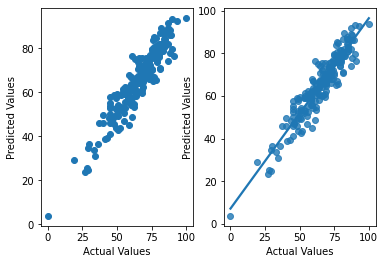

In [23]:
plt.subplot(1,2,1)
plt.scatter(y_test,y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.subplot(1,2,2)
sns.regplot(y_test,y_pred,ci=None)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')


### Difference between Actual and Predicted Values

In [24]:
pred_diff=pd.DataFrame({'Actual Values':y_test,'Predicted Values':y_pred,'Difference':y_test-y_pred})

In [25]:
pred_diff

,Actual Values,Predicted Values,Difference
521,91,76.421875,14.578125
737,53,58.953125,-5.953125
740,80,76.921875,3.078125
660,74,76.921875,-2.921875
411,84,87.796875,-3.796875
...,...,...,...
408,52,43.531250,8.468750
332,62,62.281250,-0.281250
208,74,67.734375,6.265625
613,65,67.046875,-2.046875
